In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import linregress, pearsonr
from scipy import odr
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [2]:
# Generate data for a simple 2D regression case y = m*x + b + e where e is small gaussian noise with 0 mean.
# y has 0 mean and x is uniformly sampled for simplicity. Can always Z-transform to get this. 
N = 100
m = 1.0  # m = 1.0 implies the same scale for X and Y
b = 0    # y has 0 mean

true_xs = np.arange(-5, 5, 10.0/N)
true_ys = m*true_xs + b 

# There is some underlying mechanism that produces y = m*x + b, but we have error in x and y measurements
# In particular, the error in X and Y may not have the same scale, here we have 2x the error in X even
# though they have the same scale (both ranging from -5 to 5)
err_xs = np.random.normal(0, 1.0, N)
err_ys = np.random.normal(0, 0.5, N)
measured_xs = true_xs + err_xs
measured_ys = true_ys + err_ys
pearson_corr = pearsonr(measured_xs, measured_ys)

# Ordinary linear regression fit for measurements
ols_result = linregress(measured_xs, measured_ys)
ols_m = ols_result.slope
ols_b = ols_result.intercept

ols_ys = ols_m*true_xs + ols_b
r2_ols = r2_score(true_ys, ols_ys)

In [3]:
def _lin_f(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]

# Initial guess is the OLS result
beta0 = np.array([ols_result.slope, ols_result.intercept])
odr_model = odr.Model(_lin_f)
odr_data = odr.Data(measured_xs, measured_ys)
odr_runner = odr.ODR(odr_data, odr_model, beta0=beta0)
odr_result = odr_runner.run()

odr_m, odr_b = odr_result.beta
odr_ys = odr_m*true_xs + odr_b
r2_odr = r2_score(true_ys, odr_ys)

In [10]:
print('"True" underlying relationship')
print('y = %.2f * x + %.2f' % (m, b))
print('Pearson R = %.2f, P = %.2g' % pearson_corr)
print()

print('Ordinary least squares results')
print('y = %.2f * x + %.2f' % (ols_m, ols_b))
print('R^2 = %.5f' % r2_ols)
print()

print('Total least squares results')
print('y = %.2f * x + %.2f' % (odr_m, odr_b))
print('R^2 = %.5f' % r2_odr)

"True" underlying relationship
y = 1.00 * x + 0.00
Pearson R = 0.94, P = 2.7e-46

Ordinary least squares results
y = 0.86 * x + 0.11
R^2 = 0.97991

Total least squares results
y = 0.92 * x + 0.12
R^2 = 0.99135


In [35]:
pca_solver = PCA()
Xmat = np.vstack([measured_xs, measured_ys]).T
fit_model = pca_solver.fit(Xmat)
fit_model.components_
PC1 = fit_model.components_[1]
slope = PC1[1]/PC1[0]
-1/slope

0.9182225994982358

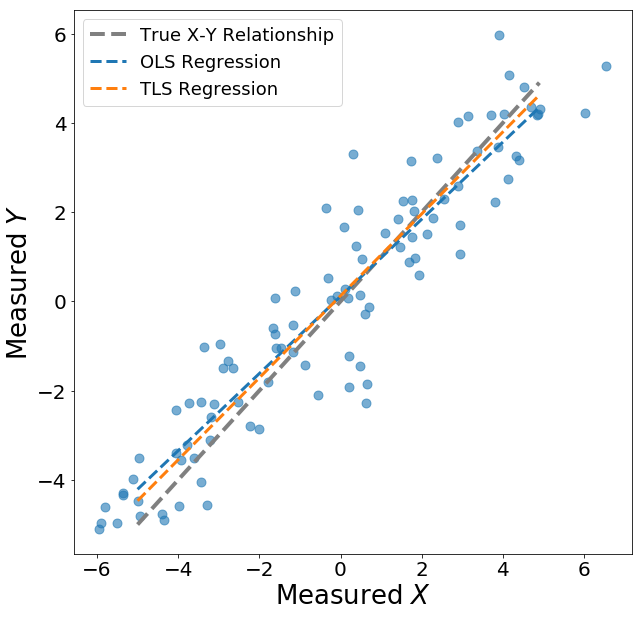

In [6]:
figure = plt.figure(figsize=(10,10))
plt.scatter(measured_xs, measured_ys, s=80, alpha=0.6)

plt.plot(true_xs, true_ys, ls='--', color='grey', lw=4, label='True X-Y Relationship')

plt.plot(true_xs, ols_ys, ls='--', lw=3, label='OLS Regression')
plt.plot(true_xs, odr_ys, ls='--', lw=3, label='TLS Regression')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Measured $X$', fontsize=26)
plt.ylabel('Measured $Y$', fontsize=26)
plt.legend(loc=2, fontsize=18)
plt.show()